## Метрики и функции потерь в регрессии

Был выбран датасет Auto MPG, так как он имеет понятную целевую переменную - расход топлива.

## 1. Подготовка

In [61]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, SGDRegressor, QuantileRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

RANDOM_STATE = 42

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

### Загрузка датасета Auto MPG

Целевая переменная: `mpg` (miles per gallon) — расход топлива \
Признаки: количество цилиндров, объём двигателя, мощность, вес, ускорение и др.

In [5]:
df = load_dataset("scikit-learn/auto-mpg")["train"].to_pandas()

print(f"Размер датасета: {df.shape}")
print(f"Признаки: {df.columns}")
df.head()

Размер датасета: (398, 9)
Признаки: Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model year', 'origin', 'car name'],
      dtype='object')


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [6]:
print("Описательная статистика:")
df.describe()

Описательная статистика:


,mpg,cylinders,displacement,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


In [7]:
print("Информация о датасете:")
print(df.info())
print(f"\nПропуски в данных:\n{df.isnull().sum()}")

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB
None

Пропуски в данных:
mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64


## 2. Подготовка данных

In [ ]:
target = "mpg"

df_clean = df.copy()

# В Auto MPG пропуски обозначены как '?'
# Проверяем количество пропусков по колонкам
# Заменяем '?' на NaN
df_clean = df_clean.replace('?', np.nan)

# Преобразуем horsepower в числовой тип (был object/string из-за '?')
df_clean['horsepower'] = df_clean['horsepower'].astype(float)

# Заполняем пропуски средним значением (mean imputation) - не совсем идеально, но лучше чем удалять строки
# Вот тут пригодилост бы предобработать данные сначала на нейронке, когда под конкретную модель реально ищутся данные horsepower
horsepower_mean = df_clean['horsepower'].mean()
df_clean['horsepower'] = df_clean['horsepower'].fillna(horsepower_mean)

print(f"\nПропуски в 'horsepower' заполнены средним значением: {horsepower_mean:.2f}")

# Определяем категориальные и числовые признаки
# origin - номинальный категориальный (1=USA, 2=Europe, 3=Japan)
# cylinders - имеет дискретные значения: 3,4,5,6,8 - количество цилиндров, поэтому это числовой признак
categorical_cols = ['origin']
numerical_cols = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year']

# Все признаки (исключаем 'car name' так как ни на что не влияет и целевую переменную mpg)
features = categorical_cols + numerical_cols

X = df_clean[features]
y = df_clean[target]

print(f"Число признаков: {X.shape[1]}")
print(f"Категориальные признаки: {categorical_cols}")
print(f"Числовые признаки: {numerical_cols}")


Пропуски в 'horsepower' заполнены средним значением: 104.47
Размер данных после обработки: 398 записей (все строки сохранены)
Число признаков: 7
Категориальные признаки: ['origin']
Числовые признаки: ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year']


### Разбиение данных

In [35]:
# Разбиение train / val / test (60 / 20 / 20) с фиксированным random_state

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE # 42
)

# 25% от оставшихся
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE
)

print(f"Train: {X_train.shape[0]} записей")
print(f"Val:   {X_val.shape[0]} записей")
print(f"Test:  {X_test.shape[0]} записей")

print(f"Total: {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]} записей")

Train: 238 записей
Val:   80 записей
Test:  80 записей
Total: 398 записей


In [36]:
# вспомогательные функции для расчёта и логирования метрик

results = {}

def calculate_metrics(y_true, y_pred):

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {"MAE": mae, "RMSE": rmse, "R^2": r2}

def log_results(model_name: str, split: str, y_true, y_pred):
    metrics = calculate_metrics(y_true, y_pred)
    
    if model_name not in results:
        results[model_name] = {}

    results[model_name][split] = metrics
    
    print(f"{model_name} [{split}]:")
    print(f"MAE:  {metrics['MAE']:.4f}")
    print(f"RMSE: {metrics['RMSE']:.4f}")
    print(f"R^2:   {metrics['R^2']:.4f}")
    
    return metrics

## 3. Построение бейзлайн-моделей

In [51]:
# предсказание средним значением

mean_value = y_train.mean()
print(f"Среднее значение y_train: {mean_value:.4f}")

y_pred_mean_train = np.full(len(y_train), mean_value)
y_pred_mean_val = np.full(len(y_val), mean_value)

log_results("Baseline (mean)", "train", y_train, y_pred_mean_train)
log_results("Baseline (mean)", "val", y_val, y_pred_mean_val)

Среднее значение y_train: 23.2609
Baseline (mean) [train]:
MAE:  6.4765
RMSE: 7.6368
R^2:   0.0000
Baseline (mean) [val]:
MAE:  7.2347
RMSE: 8.7288
R^2:   -0.0256


{'MAE': 7.234726890756302,
 'RMSE': np.float64(8.728829949256136),
 'R^2': -0.025647749905760575}

In [52]:
# предсказание медианой

median_value = y_train.median()
print(f"Медиана y_train: {median_value:.4f}")

y_pred_median_train = np.full(len(y_train), median_value)
y_pred_median_val = np.full(len(y_val), median_value)

log_results("Baseline (median)", "train", y_train, y_pred_median_train)
log_results("Baseline (median)", "val", y_val, y_pred_median_val)

Медиана y_train: 22.1500
Baseline (median) [train]:
MAE:  6.4416
RMSE: 7.7172
R^2:   -0.0212
Baseline (median) [val]:
MAE:  7.2888
RMSE: 8.9718
R^2:   -0.0835


{'MAE': 7.28875,
 'RMSE': np.float64(8.971816984312598),
 'R^2': -0.08354506269809225}

### Анализ

Предсказание средним значением и предсказание медианой - это пример константных моделей.


1. R^2 ~ 0 для обоих бейзлайнов - ожидаемо, так как это константные модели и по определению они не могут объяснить вариативность данных. Предсказание средним вообще по определению даёт 0. Эти модели не используют признаки и не объясняют структуру данных. Или иначе - модель не извлекла никакой информации из данных (ничего не выучила). В идеале любая адекватная модель должна иметь значение лучше (> 0).

2. MAE vs RMSE:
RMSE обычно больше MAE, потому что квадратичная ошибка сильнее наказывает большие отклонения. Предсказание медианой минимизирует MAE, а предсказание средним минимизирует RMSE.

## 4. Обучение линейной модели

In [53]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
])

linreg_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

# Обучаем
linreg_pipeline.fit(X_train, y_train)

# Предсказания
y_pred_linreg_train = linreg_pipeline.predict(X_train)
y_pred_linreg_val = linreg_pipeline.predict(X_val)

log_results("LinearRegression", "train", y_train, y_pred_linreg_train)
log_results("LinearRegression", "val", y_val, y_pred_linreg_val)

LinearRegression [train]:
MAE:  2.5022
RMSE: 3.1910
R^2:   0.8254
LinearRegression [val]:
MAE:  2.9472
RMSE: 3.9210
R^2:   0.7930


{'MAE': 2.9471782903622157,
 'RMSE': np.float64(3.920952647723884),
 'R^2': 0.7930481272298315}

In [54]:
comparison_df = pd.DataFrame({
    "Model": ["Baseline (mean)", "Baseline (median)", "LinearRegression"],
    "MAE": [
        results["Baseline (mean)"]["val"]["MAE"],
        results["Baseline (median)"]["val"]["MAE"],
        results["LinearRegression"]["val"]["MAE"]
    ],
    "RMSE": [
        results["Baseline (mean)"]["val"]["RMSE"],
        results["Baseline (median)"]["val"]["RMSE"],
        results["LinearRegression"]["val"]["RMSE"]
    ],
    "R^2": [
        results["Baseline (mean)"]["val"]["R^2"],
        results["Baseline (median)"]["val"]["R^2"],
        results["LinearRegression"]["val"]["R^2"]
    ]
})

print(comparison_df.to_string(index=False))

            Model      MAE     RMSE       R^2
  Baseline (mean) 7.234727 8.728830 -0.025648
Baseline (median) 7.288750 8.971817 -0.083545
 LinearRegression 2.947178 3.920953  0.793048


LinearRegression значительно превосходит бейзлайны по всем метрикам:

По MAE - бейзлайны ошибаются в среднем на 7.2 единиц целевой переменной. LinearRegression ошибается на 2.95.

LinearRegression объясняет 79% вариации в данных.
Признаки действительно имеют сильную линейную связь с расходом топлива.

Ошибка уменьшилась более чем в 2 раза.

Вывод: линейная регрессия здесь работает намного лучше бейзлайнов.

### Визуализация результатов LinearRegression

1. Диаграмма соответствия
2. График остатков

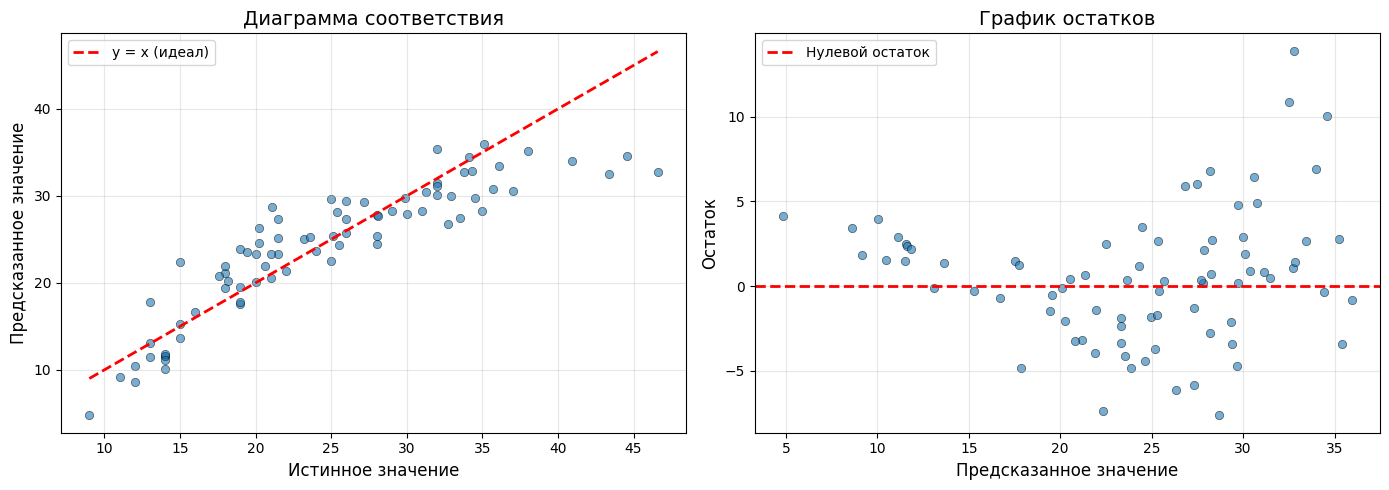

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: y_true vs y_pred с линией y=x
ax1 = axes[0]
ax1.scatter(y_val, y_pred_linreg_val, alpha=0.6, edgecolors='black', linewidth=0.5)
ax1.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', linewidth=2, label='y = x (идеал)')
ax1.set_xlabel("Истинное значение", fontsize=12)
ax1.set_ylabel("Предсказанное значение", fontsize=12)
ax1.set_title("Диаграмма соответствия", fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# График 2: Остатки vs предсказания
residuals_val = y_val - y_pred_linreg_val
ax2 = axes[1]
ax2.scatter(y_pred_linreg_val, residuals_val, alpha=0.6, edgecolors='black', linewidth=0.5)
ax2.axhline(0, color='r', linestyle='--', linewidth=2, label='Нулевой остаток')
ax2.set_xlabel("Предсказанное значение", fontsize=12)
ax2.set_ylabel("Остаток", fontsize=12)
ax2.set_title("График остатков", fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Анализ графиков

**1. Диаграмма соответствия (y vs ŷ):**
- Точки располагаются вдоль линии `y = x`, что говорит о хорошем качестве предсказаний
- Но рассеяние точек увеличивается для больших значений, что может указывать на гетероскедастичность

**2. График остатков:**
- Наблюдается гетероскедастичность

**Выводы:**
- Модель линейной регрессии показывает адекватные результаты
- Но возможно присутствие гетероскедастичности

## 5. Сравнение функций потерь: MSE vs MAE

- **MSE (Mean Squared Error)** — квадратичная ошибка, сильнее штрафует большие отклонения
- **MAE (Mean Absolute Error)** — абсолютная ошибка, более устойчива к выбросам

Для сравнения используем:
- `SGDRegressor(loss='squared_error')` — оптимизация MSE через градиентный спуск
- `SGDRegressor(loss='epsilon_insensitive', epsilon=0)` — оптимизация MAE через градиентный спуск

In [62]:

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

mse_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", SGDRegressor(
        loss='squared_error',  # MSE loss
        max_iter=10000,
        tol=1e-4,
        random_state=RANDOM_STATE,
        early_stopping=True,
        validation_fraction=0.1
    ))
])

mse_pipeline.fit(X_train, y_train)

y_pred_mse_train = mse_pipeline.predict(X_train)
y_pred_mse_val = mse_pipeline.predict(X_val)

log_results("SGD (MSE loss)", "train", y_train, y_pred_mse_train)
log_results("SGD (MSE loss)", "val", y_val, y_pred_mse_val)

SGD (MSE loss) [train]:
MAE:  2.5035
RMSE: 3.2770
R^2:   0.8159
SGD (MSE loss) [val]:
MAE:  2.9901
RMSE: 3.9871
R^2:   0.7860


{'MAE': 2.9900940985718227,
 'RMSE': np.float64(3.9870809745132156),
 'R^2': 0.7860086208462391}

In [ ]:
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# epsilon_insensitive с epsilon=0 даёт чистую MAE
mae_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", SGDRegressor(
        loss='epsilon_insensitive',
        epsilon=0,  # При epsilon=0 это эквивалентно MAE
        max_iter=10000,
        tol=1e-4,
        random_state=RANDOM_STATE,
        early_stopping=True,
        validation_fraction=0.1
    ))
])

mae_pipeline.fit(X_train, y_train)

y_pred_mae_train = mae_pipeline.predict(X_train)
y_pred_mae_val = mae_pipeline.predict(X_val)

log_results("SGD (MAE loss)", "train", y_train, y_pred_mae_train)
log_results("SGD (MAE loss)", "val", y_val, y_pred_mae_val)

SGD (MAE loss) [train]:
MAE:  2.5212
RMSE: 3.5708
R^2:   0.7814
SGD (MAE loss) [val]:
MAE:  2.9742
RMSE: 4.2539
R^2:   0.7564


{'MAE': 2.9742355862941223,
 'RMSE': np.float64(4.253927803542657),
 'R^2': 0.7564061072672541}

In [65]:
loss_comparison_df = pd.DataFrame({
    "Model": ["LinearRegression", "SGD (MSE loss)", "SGD (MAE loss)"],
    "Loss Function": ["MSE", "MSE", "MAE"],
    "MAE": [
        results["LinearRegression"]["val"]["MAE"],
        results["SGD (MSE loss)"]["val"]["MAE"],
        results["SGD (MAE loss)"]["val"]["MAE"]
    ],
    "RMSE": [
        results["LinearRegression"]["val"]["RMSE"],
        results["SGD (MSE loss)"]["val"]["RMSE"],
        results["SGD (MAE loss)"]["val"]["RMSE"]
    ],
    "R^2": [
        results["LinearRegression"]["val"]["R^2"],
        results["SGD (MSE loss)"]["val"]["R^2"],
        results["SGD (MAE loss)"]["val"]["R^2"]
    ]
})

print(loss_comparison_df.to_string(index=False))

           Model Loss Function      MAE     RMSE      R^2
LinearRegression           MSE 2.947178 3.920953 0.793048
  SGD (MSE loss)           MSE 2.990094 3.987081 0.786009
  SGD (MAE loss)           MAE 2.974236 4.253928 0.756406


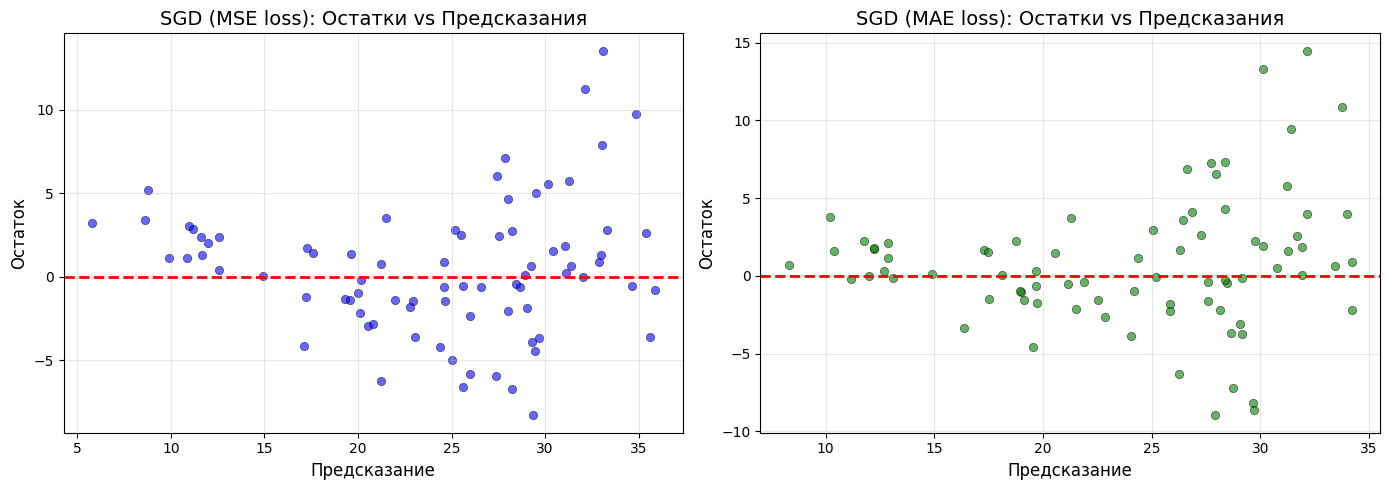

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Остатки для MSE loss
residuals_mse = y_val - y_pred_mse_val
ax1 = axes[0]
ax1.scatter(y_pred_mse_val, residuals_mse, alpha=0.6, color='blue', edgecolors='black', linewidth=0.5)
ax1.axhline(0, color='r', linestyle='--', linewidth=2)
ax1.set_xlabel("Предсказание", fontsize=12)
ax1.set_ylabel("Остаток", fontsize=12)
ax1.set_title("SGD (MSE loss): Остатки vs Предсказания", fontsize=14)
ax1.grid(True, alpha=0.3)

# Остатки для MAE loss
residuals_mae = y_val - y_pred_mae_val
ax2 = axes[1]
ax2.scatter(y_pred_mae_val, residuals_mae, alpha=0.6, color='green', edgecolors='black', linewidth=0.5)
ax2.axhline(0, color='r', linestyle='--', linewidth=2)
ax2.set_xlabel("Предсказание", fontsize=12)
ax2.set_ylabel("Остаток", fontsize=12)
ax2.set_title("SGD (MAE loss): Остатки vs Предсказания", fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Анализ влияния функции потерь

**Теоретические различия:**

| Функция потерь | Характеристика | Чувствительность к выбросам |
|----------------|----------------|----------------------------|
| **MSE** | Квадратичный штраф за ошибки | Высокая (выбросы сильно влияют) |
| **MAE** | Линейный штраф за ошибки | Низкая (более устойчива) |

**Практические выводы:**

Архитектура модели одинаковая, это все та же линейная регрессия, важно оценить, как эта модель наказывается за ошибку. 
MAE почти у всех одинаковый, но MSE модель и LinearRegression дают лучшие результаты. Что также показывает лучшие R^2.

Хотя MAE модель и достигает сопоставимого значения средней абсолютной ошибки, она хуже контролирует крупные отклонения, что приводит к увеличению MSE и снижению коэффициента детерминации R^2.
Это указывает на отсутствие значимых выбросов в данных и подтверждает, что квадратичная функция потерь является более подходящей для данной задачи.

## 6. Финальная оценка на тестовой выборке

**Выбор модели:** LinearRegression

**Обоснование выбора ключевой метрики:**
- **MSE** выбрана как основная метрика, так как:
  1. Измеряется в тех же единицах, что и целевая переменная
  2. Сильнее штрафует большие ошибки, что важно для практических приложений

In [80]:
# Используем обученный ранее linreg_pipeline
y_pred_test = linreg_pipeline.predict(X_test)

test_metrics = log_results("LinearRegression", "test", y_test, y_pred_test)

LinearRegression [test]:
MAE:  2.3303
RMSE: 2.9092
R^2:   0.8426


In [81]:
# Сравнение train / val / test для оценки стабильности

stability_df = pd.DataFrame({
    "Split": ["Train", "Validation", "Test"],
    "MAE": [
        results["LinearRegression"]["train"]["MAE"],
        results["LinearRegression"]["val"]["MAE"],
        results["LinearRegression"]["test"]["MAE"]
    ],
    "RMSE": [
        results["LinearRegression"]["train"]["RMSE"],
        results["LinearRegression"]["val"]["RMSE"],
        results["LinearRegression"]["test"]["RMSE"]
    ],
    "R^2": [
        results["LinearRegression"]["train"]["R^2"],
        results["LinearRegression"]["val"]["R^2"],
        results["LinearRegression"]["test"]["R^2"]
    ]
})

print(stability_df.to_string(index=False))

# Анализ стабильности
train_rmse = results["LinearRegression"]["train"]["RMSE"]
test_rmse = results["LinearRegression"]["test"]["RMSE"]
diff_percent = abs(test_rmse - train_rmse) / train_rmse * 100

print(f"Разница RMSE (train vs test): {diff_percent:.1f}%")

if diff_percent < 10:
    print("Модель стабильна: разница между train и test менее 10%")
elif diff_percent < 20:
    print("Модель умеренно стабильна: разница между train и test 10-20%")
else:
    print("Возможно переобучение: разница между train и test более 20%")

     Split      MAE     RMSE      R^2
     Train 2.502249 3.190963 0.825410
Validation 2.947178 3.920953 0.793048
      Test 2.330325 2.909196 0.842589
Разница RMSE (train vs test): 8.8%
Модель стабильна: разница между train и test менее 10%


In [84]:
all_models = ["Baseline (mean)", "Baseline (median)", "LinearRegression", "SGD (MSE loss)", "SGD (MAE loss)"]

summary_data = []
for model in all_models:
    if "val" in results.get(model, {}):
        summary_data.append({
            "Model": model,
            "MAE (val)": results[model]["val"]["MAE"],
            "RMSE (val)": results[model]["val"]["RMSE"],
            "R^2 (val)": results[model]["val"]["R^2"]
        })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\nЛучшая модель по RMSE: LinearRegression")

            Model  MAE (val)  RMSE (val)  R^2 (val)
  Baseline (mean)   7.234727    8.728830  -0.025648
Baseline (median)   7.288750    8.971817  -0.083545
 LinearRegression   2.947178    3.920953   0.793048
   SGD (MSE loss)   2.990094    3.987081   0.786009
   SGD (MAE loss)   2.974236    4.253928   0.756406

Лучшая модель по RMSE: LinearRegression


## 7. Выводы

### Основные результаты:

1. **Подготовка данных:**
   - Использован датасет Auto MPG с целевой переменной расход топлива
   - Данные разбиты на train/val/test (60/20/20) с фиксированным random_state
   - Применён Pipeline с ColumnTransformer (OneHotEncoder + StandardScaler) для предотвращения утечки данных

2. **Бейзлайны:**
   - Константные предсказатели (mean, median) дают R^2 около 0 на train
   - Бейзлайны определяют нижнюю границу качества для сравнения

3. **LinearRegression:**
   - Значительно превосходит бейзлайны по всем метрикам
   - R^2 около 0.8 на валидации — модель объясняет около 80% вариации
   - Графики остатков показывают наличие гетероскедастичности

4. **Сравнение функций потерь:**
   - MSE и MAE дают схожие результаты на данном датасете
   - Это говорит об отсутствии сильных выбросов в данных
   - При наличии выбросов MAE была бы предпочтительнее

5. **Стабильность модели:**
   - Метрики на train и test близки — модель не переобучена
   - LinearRegression выбрана как финальная модель

### Ключевая метрика: RMSE
- Измеряется в единицах целевой переменной (расход топлива mpg)

## Бонус: Дополнительная функция потерь — Quantile Loss

**QuantileRegressor** минимизирует quantile loss. При `quantile=0.5` это эквивалентно минимизации MAE (медианная регрессия).

Quantile loss позволяет предсказывать не только медиану, но и любой квантиль распределения.

In [85]:
# QuantileRegressor с quantile=0.5 минимизирует MAE (медианная регрессия)
quantile_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", QuantileRegressor(
        quantile=0.5,  # Медиана = минимизация MAE
        alpha=0,  # Без регуляризации
        solver='highs'
    ))
])

quantile_pipeline.fit(X_train, y_train)

y_pred_quantile_train = quantile_pipeline.predict(X_train)
y_pred_quantile_val = quantile_pipeline.predict(X_val)

log_results("QuantileRegressor (MAE)", "train", y_train, y_pred_quantile_train)
log_results("QuantileRegressor (MAE)", "val", y_val, y_pred_quantile_val)

QuantileRegressor (MAE) [train]:
MAE:  2.4302
RMSE: 3.3473
R^2:   0.8079
QuantileRegressor (MAE) [val]:
MAE:  2.8552
RMSE: 4.0092
R^2:   0.7836


{'MAE': 2.8551734015291412,
 'RMSE': np.float64(4.009197407801619),
 'R^2': 0.7836280058730938}

In [88]:
# Сравнение с разными квантилями
quantile_values = [0.1, 0.25, 0.5, 0.75, 0.9]
quantile_results = []

for q in quantile_values:
    q_pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", QuantileRegressor(quantile=q, alpha=0, solver='highs'))
    ])
    
    q_pipe.fit(X_train, y_train)
    y_pred_q = q_pipe.predict(X_val)
    
    metrics = calculate_metrics(y_val, y_pred_q)
    quantile_results.append({
        "Quantile": q,
        "MAE": metrics["MAE"],
        "RMSE": metrics["RMSE"],
        "R^2": metrics["R^2"]
    })

quantile_df = pd.DataFrame(quantile_results)
print(quantile_df.to_string(index=False))

 Quantile      MAE     RMSE      R^2
     0.10 4.635860 6.086153 0.501377
     0.25 3.611148 4.886425 0.678583
     0.50 2.855173 4.009197 0.783628
     0.75 3.090032 4.049785 0.779225
     0.90 4.203912 5.172007 0.639916


**Quantile loss (QuantileRegressor) выводы:**

Квантильная регрессия оптимизирует асимметричную абсолютную ошибку и позволяет модели предсказывать не среднее значение целевой переменной, а заданный квантиль её распределения. Это хорошо видно в результатах: при quantile = 0.5 модель показывает наилучшие значения MAE и R^2, так как медианная регрессия эквивалентна оптимизации MAE и даёт наиболее типичное предсказание. При смещении к нижним (0.1, 0.25) или верхним (0.75, 0.9) квантилям качество по MAE и R^2 ухудшается, поскольку модель целенаправленно начинает недооценивать или переоценивать целевую переменную. Таким образом, QuantileRegressor не предназначен для максимизации общей точности, а используется для анализа распределения откликов и построения условных интервалов, тогда как квантиль 0.5 даёт результаты, сопоставимые с MAE-оптимизированными линейными моделями.